## A time series version Transformer for Time series data
### Refer to the original transformer, but with difference
Reference: https://www.tensorflow.org/tutorials/text/transformer
### Split into short and long term model
### need do re-think the MAE/MSE/cross entropy loss problem


In [1]:
import numpy as np
import tensorflow as tf
import os
import pandas as pd
from sklearn import preprocessing

import time
from sklearn.model_selection import train_test_split 


plot_path = "plots/"

# Real server data

root_path = "Data/Ant_202007/"




In [2]:
# Data

cif = pd.read_json(root_path+'cif.json', orient='index')
paycore = pd.read_json(root_path+'paycore.json', orient='index')
paydecision = pd.read_json(root_path+'paydecision.json', orient='index')
paydecision2 = pd.read_json(root_path+'paydecision2.json', orient='index')
paydecision3 = pd.read_json(root_path+'paydecision3.json', orient='index')

df = pd.DataFrame()
df["time_stamp"] = cif.index
df["cif"] = cif[0].values
df["paycore"] = paycore[0].values
df["paydecision"] = paydecision[0].values
df["paydecision2"] = paydecision2[0].values
df["paydecision3"] = paydecision3[0].values

# Optional
if False:
    df.to_csv(root_path+"fusion.csv")

    
# convert time stamp
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
names_array = np.array(df.keys()[1:],dtype="str")
os.listdir(root_path)


if True:
    
    # calculate previous hour high low:
    # convert to seconds
    temp = df['time_stamp'] - min(df['time_stamp'])
    temp = temp.dt.total_seconds().astype(int)
    df["hours"] = temp//3600

    h_max = max(df["hours"])+1

    for n in range(len(names_array)):
        df[names_array[n]+"_open"] = df[names_array[n]]
        df[names_array[n]+"_close"] = df[names_array[n]]
        df[names_array[n]+"_max"] = df[names_array[n]]
        df[names_array[n]+"_min"] = df[names_array[n]]

    for j in range(1,h_max):
        mask_j = df["hours"]==j-1
        max_val = df[mask_j][names_array].max(axis=0).values
        min_val = df[mask_j][names_array].max(axis=0).values
        open_val = df[mask_j][names_array].values[0,:]
        close_val = df[mask_j][names_array].values[-1,:]
        mask_i = df["hours"]==j
        r = df[mask_i][names_array].shape[0]
        df.loc[mask_i,[r+"_open" for r in names_array]] = np.tile(open_val,(r,1))
        df.loc[mask_i,[r+"_close" for r in names_array]] = np.tile(close_val,(r,1))

        df.loc[mask_i,[r+"_max" for r in names_array]] = np.tile(max_val,(r,1))
        df.loc[mask_i,[r+"_min" for r in names_array]] = np.tile(min_val,(r,1))
        
    
    
    




In [3]:
# scale dot attention:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    # Dimension of k
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    # calculate attention weight:
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

# Multi-head Attention:
# This is what we use
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        
        # Always use Super to inheriatte and avoid extra code.
        assert d_model%num_heads==0
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        # sanity check:
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        # Q K W:
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
    def split_heads(self, x, batch_size):
        # Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # https://www.tensorflow.org/api_docs/python/tf/transpose : perm
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights
    
    
        
        


In [4]:
## Encoder decoder for Time series:

# pointwise feed forward network
def point_wise_feed_forward_network(d_model, dff):
    # Two FC layers:
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

# Change embedding since it's not int anymore:
class EmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self,embedding_size):
        super(EmbeddingLayer,self).__init__()
        self.embedding_size=embedding_size

    def build(self,input_shape):
        with tf.name_scope('embedding'):
            self.shared_weights=self.add_weight(name='weights',
                                                shape=[input_shape[-1],self.embedding_size],
                                                initializer=tf.random_normal_initializer(mean=0.,
                                                                                         stddev=self.embedding_size ** -0.5))
        super(EmbeddingLayer,self).build(input_shape)


    def call(self,x):
        y=tf.einsum('bsf,fk->bsk',x,self.shared_weights)
        return y
    

class EncoderLayer(tf.keras.layers.Layer):
    # Here we use a 0.1 dropout rate as default
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
        return out2
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

print(sample_encoder_layer_output.shape)  # (batch_size, input_seq_len, d_model)

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

print(sample_decoder_layer_output.shape)  # (batch_size, target_seq_len, d_model)
    

(64, 43, 512)
(64, 50, 512)


In [5]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
    
        # adding embedding and position encoding.
        #print("Check",x.shape)
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        #x = tf.keras.layers.Dense(self.d_model)(x)
        #print("check 2",x.shape)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        #print("check 3",x.shape)

        x = self.dropout(x, training=training)
        #print("check 4",x.shape)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x  # (batch_size, input_seq_len, d_model)
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        #x = tf.keras.layers.Dense(self.d_model)(x)
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights
    

In [7]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_seq_size, 
               output_seq_size, input_delta_t, output_delta_t, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_seq_size, input_delta_t, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               output_seq_size, output_delta_t, rate)

        self.final_layer = tf.keras.layers.Dense(output_seq_size)


    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        #print("check encoder size",enc_output.shape)

    
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        #print("check decoder size",dec_output.shape)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights


In [9]:
# We encoder the float32 input to input_seq_size/output_seq_size integers
# The output is a sliding time table for different time scale prediction:
# Eg: you need to make sure your prediction delta_t<output delta_t and input data delta_t < input_delta_t
# For GTX 1060 we can set batch=16 and use 4X batch size for Tesla P40

batch = 8

sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_seq_size=1000, output_seq_size=1000, 
    input_delta_t=1440, output_delta_t=240)

# input: batch+sequence length
# biggest length for in/out put is pe_input,  pe_target
temp_input = tf.random.uniform((batch, 720), dtype=tf.int64, minval=0, maxval=1000)
temp_target = tf.random.uniform((batch, 3), dtype=tf.int64, minval=0, maxval=1000)

#temp_input = tf.cast(temp_input,dtype=tf.float32)
#temp_target = tf.cast(temp_target,dtype=tf.float32)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

print("final output size",fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size)

final output size (8, 3, 1000)


In [15]:
# prepare data: fow now I only use 1D data, but it can be extended to multiple channel:
# Load data:names_array


temp = df["cif"]
# Normalize to 0-1000

temp = (temp-min(temp))/(max(temp)-min(temp))

lower, upper = 0, 999
temp = [lower + (upper - lower) * x for x in temp]
temp = np.array(temp,dtype=int)
delta_t = 720
delta_t_out = 3


X = np.zeros((temp.shape[0]-delta_t-delta_t_out,delta_t,1),dtype=int)

for i in range(delta_t_out):
    if i==0:
        y = temp[delta_t:-delta_t_out]
    else:
        y = np.c_[y,temp[delta_t+i:-(delta_t_out-i)]]
    
    
for i in range(y.shape[0]):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = np.atleast_2d(temp[i:i+delta_t]).T


train_dataset_TS = tf.data.Dataset.from_tensor_slices((X,y))

Prepare data 0.00 percent
Prepare data 24.37 percent
Prepare data 48.74 percent
Prepare data 73.10 percent
Prepare data 97.47 percent


Text(0.5, 0, 'Train Step')

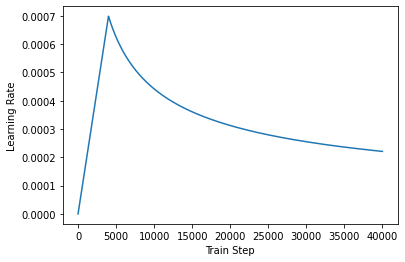

In [16]:
## Optimizor:
import matplotlib.pyplot as plt

d_model=512

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
# Learning rate curve:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [17]:
# Loss function:
# loss and metric

# For now I use sparse-cross entropy. But MAE may make more sense here:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)




train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [18]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

      
    return enc_padding_mask, combined_mask, dec_padding_mask

In [34]:


batch = 8

transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_seq_size=1000, output_seq_size=1000, 
    input_delta_t=1440, output_delta_t=240)




checkpoint_path = "./checkpoints/train_TS"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')



train_step_signature = [
        tf.TensorSpec(shape=(None, None), dtype=tf.int64),
        tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    ]

@tf.function(input_signature=train_step_signature)

def train_step(inp, tar):
        
    tar_inp = tar
    tar_real = tar

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)









In [ ]:
#Train and save:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

EPOCHS = 10
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
batch=16

N = len(y_train)

for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
    for i in range(N//batch):
        inp, tar=X_train[batch*i:min(batch*i+batch,N),:,0],y_train[batch*i:min(batch*i+batch,N)]
        tar = np.atleast_2d(tar)
        lo = train_step(inp, tar)
        if i%200==0:
            print("Doing %d (%d) batch in epoch %d "%(i,N//batch,epoch))
            print("Loss",train_loss.result(), "Accuracy",train_accuracy.result())
    
  

Doing 0 (1795) batch in epoch 0 
Loss tf.Tensor(7.3270817, shape=(), dtype=float32) Accuracy tf.Tensor(0.0, shape=(), dtype=float32)
Doing 200 (1795) batch in epoch 0 
Loss tf.Tensor(6.7499447, shape=(), dtype=float32) Accuracy tf.Tensor(0.012437811, shape=(), dtype=float32)
Doing 400 (1795) batch in epoch 0 
Loss tf.Tensor(5.281816, shape=(), dtype=float32) Accuracy tf.Tensor(0.24522029, shape=(), dtype=float32)
Doing 600 (1795) batch in epoch 0 
Loss tf.Tensor(3.950485, shape=(), dtype=float32) Accuracy tf.Tensor(0.4592693, shape=(), dtype=float32)
Doing 800 (1795) batch in epoch 0 
Loss tf.Tensor(3.0790226, shape=(), dtype=float32) Accuracy tf.Tensor(0.58598626, shape=(), dtype=float32)
Doing 1000 (1795) batch in epoch 0 
Loss tf.Tensor(2.5135214, shape=(), dtype=float32) Accuracy tf.Tensor(0.66496, shape=(), dtype=float32)
Doing 1200 (1795) batch in epoch 0 
Loss tf.Tensor(2.1059744, shape=(), dtype=float32) Accuracy tf.Tensor(0.7201464, shape=(), dtype=float32)
Doing 1400 (1795) b

In [ ]:
# testing:
N_test = len(y_test)

y_pred_all = []
for i in range(N_test//batch):
    if i%200==0:
            print("Doing %d (%d)"%(i,N_test//batch))
    
    inp, tar=X_test[batch*i:min(batch*i+batch,N),:,0],y_test[batch*i:min(batch*i+batch,N)]
    tar = np.atleast_2d(tar).T
    tar_inp = tar
    tar_real = tar

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    predictions, attention_weights = transformer(inp, 
                                                 tar,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    y_pred_all.append(tf.cast(tf.argmax(predictions, axis=-1), tf.int32))


    
    


In [ ]:
# plot:

import matplotlib
from matplotlib.pylab import rc


font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

plt.plot(y_test[:3000],"k",label="Data")
plt.plot(y_pred_all[:3000],"r",label="Prediction-Transformer")
diff = y_test[:3000]-y_pred_all[:3000]
plt.plot(diff,"b",label="Difference")

plt.xlabel("Time")
plt.ylabel(r"CIF")
plt.suptitle("Value vs day")

fig = matplotlib.pyplot.gcf()
plt.legend()

fig.set_size_inches(35,12)

save_path = plot_path + "Transformer_CIF_short" + ".png"

fig.savefig(save_path, dpi=200)





In [ ]:


font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

plt.hist(diff/np.nanmean(y_test))
plt.xlabel("Difference/mean")


fig = matplotlib.pyplot.gcf()
plt.legend()

fig.set_size_inches(35,12)

save_path = plot_path + "Transformer_CIF_diff_short_hist" + ".png"

fig.savefig(save_path, dpi=200)





In [ ]:
# Let's do some lone term prediction like 60 minutes?

# You need to re-train the model since this model is only for short-term.